# Pascal VOC 2007 - Localização (Bounding Box) e Classificação

In [1]:
!wget -nc http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget -nc https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip

URL transformed to HTTPS due to an HSTS policy
O arquivo “VOCtrainval_06-Nov-2007.tar” já existe, não será baixado.

O arquivo “PASCAL_VOC.zip” já existe, não será baixado.



In [2]:
!tar xf VOCtrainval_06-Nov-2007.tar
!unzip -qq -n PASCAL_VOC.zip

In [3]:
train_annotation_path = 'PASCAL_VOC/pascal_train2007.json'
valid_annotation_path = 'PASCAL_VOC/pascal_val2007.json'
images_path = 'VOCdevkit/VOC2007/JPEGImages'

## Setup

#### Pacotes gerais

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from IPython import display

import os
import time
import json
import pprint
import random
import pkgutil

import cv2
import numpy as np

from skimage import transform

#### Setup para Google Colab

In [5]:
if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

#### Pacotes do Pytorch

In [6]:
import torch
import torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Carregando dados

In [7]:
def loadJson(json_path):
    json_obj = None

    try:
        json_file = open(json_path, 'r')
        json_obj = json.load(json_file)
        json_file.close()
    except:
        pass

    return json_obj

In [8]:
train_annotation = loadJson(train_annotation_path)
valid_annotation = loadJson(valid_annotation_path)

#### Verificando anotações de treinamento

In [9]:
train_annotation_count = {key: len(train_annotation[key]) for key in train_annotation if key != 'type'}
train_annotation_sample = {key: train_annotation[key][0] for key in train_annotation if key != 'type'}
print(f'Contagem: {pprint.pformat(train_annotation_count)}\n')
print(f'Amostra:\n{pprint.pformat(train_annotation_sample)}')

Contagem: {'annotations': 7844, 'categories': 20, 'images': 2501}

Amostra:
{'annotations': {'area': 34104,
                 'bbox': [155, 96, 196, 174],
                 'category_id': 7,
                 'id': 1,
                 'ignore': 0,
                 'image_id': 12,
                 'iscrowd': 0,
                 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 'categories': {'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 'images': {'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500}}


#### Verificando anotações de validação

In [10]:
valid_annotation_count = {key: len(valid_annotation[key]) for key in valid_annotation if key != 'type'}
valid_annotation_sample = {key: valid_annotation[key][0] for key in valid_annotation if key != 'type'}
print(f'Contagem: {pprint.pformat(valid_annotation_count)}\n')
print(f'Amostra:\n{pprint.pformat(valid_annotation_sample)}')

Contagem: {'annotations': 7818, 'categories': 20, 'images': 2510}

Amostra:
{'annotations': {'area': 7998,
                 'bbox': [262, 210, 62, 129],
                 'category_id': 9,
                 'id': 1,
                 'ignore': 0,
                 'image_id': 5,
                 'iscrowd': 0,
                 'segmentation': [[262, 210, 262, 339, 324, 339, 324, 210]]},
 'categories': {'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 'images': {'file_name': '000005.jpg', 'height': 375, 'id': 5, 'width': 500}}


#### Verificando categorias

In [11]:
train_annotation_categ = {entry['id']: entry['name'] for entry in train_annotation['categories']}
valid_annotation_categ = {entry['id']: entry['name'] for entry in valid_annotation['categories']}
if train_annotation_categ == valid_annotation_categ:
    print(f'Categorias idênticas entre os conjuntos de treinamento e validação:\n')
    pprint.pprint(train_annotation_categ)
else:
    print(f'Categorias diferentes entre os conjuntos de treinamento e validação')

Categorias idênticas entre os conjuntos de treinamento e validação:

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}


#### Estruturando anotações

Os dados vem pré-separados nestes conjuntos de treinamento e validação, por isso será criada uma estrutura única para conter ambos, facilitando a divisão posterior em conjuntos de tamanho desejado. Também serão filtradas as informações desnecessárias para a classificação (categoria) e localização (bounding box).

In [12]:
def reformatAnnotation(annotation):
    annotation_dict = {entry['id']: {'file_name': os.path.join(images_path, entry['file_name']),
                                     'height': entry['height'],
                                     'width': entry['width']} for entry in annotation['images']}

    for entry in annotation['annotations']:
        if entry['ignore'] != 0:
            continue

        image_id = entry['image_id']
        height = annotation_dict[image_id]['height']
        width = annotation_dict[image_id]['width']

        if annotation_dict[image_id].get('annot', None) is None:
            annotation_dict[image_id]['annot'] = list()

        annotation_dict[image_id]['annot'].append(dict(bbox=entry['bbox'],
                                                       categ=entry['category_id'],
                                                       area=entry['area']))

    for entry in annotation_dict:
        annotation_dict[entry]['annot'] = sorted(annotation_dict[entry]['annot'], key=lambda k: k['area'], reverse=True)

    return annotation_dict

In [13]:
train_annotation_dict = reformatAnnotation(train_annotation)
valid_annotation_dict = reformatAnnotation(valid_annotation)

In [14]:
annotation_dict = {**train_annotation_dict, **valid_annotation_dict}
annotation_ids = list(annotation_dict.keys())
print(f'Total de amostras: {len(annotation_ids)}\n')

print('Amostras estruturadas:')
for entry in range(3):
    image_id = annotation_ids[entry]
    print(f'\n{image_id}:')
    pprint.pprint(annotation_dict[image_id])

Total de amostras: 5011

Amostras estruturadas:

12:
{'annot': [{'area': 34104, 'bbox': [155, 96, 196, 174], 'categ': 7}],
 'file_name': 'VOCdevkit/VOC2007/JPEGImages/000012.jpg',
 'height': 333,
 'width': 500}

17:
{'annot': [{'area': 81326, 'bbox': [89, 77, 314, 259], 'categ': 13},
           {'area': 13110, 'bbox': [184, 61, 95, 138], 'categ': 15}],
 'file_name': 'VOCdevkit/VOC2007/JPEGImages/000017.jpg',
 'height': 364,
 'width': 480}

23:
{'annot': [{'area': 111101, 'bbox': [2, 1, 241, 461], 'categ': 15},
           {'area': 64227, 'bbox': [8, 229, 237, 271], 'categ': 2},
           {'area': 53460, 'bbox': [224, 0, 110, 486], 'categ': 15},
           {'area': 42804, 'bbox': [1, 0, 116, 369], 'categ': 15},
           {'area': 29505, 'bbox': [229, 219, 105, 281], 'categ': 2}],
 'file_name': 'VOCdevkit/VOC2007/JPEGImages/000023.jpg',
 'height': 500,
 'width': 334}


#### Visualizando amostras

In [15]:
def drawBbox(ax, bbox, label, box_color='blue'):
    ax.add_patch(patches.Rectangle(bbox[:2], bbox[2], bbox[3],
                                   fill=False, edgecolor=box_color, lw=2))

    text = ax.text(bbox[0], bbox[1], label, verticalalignment='top',
                   color='white', fontsize=12, weight='bold')
    text.set_path_effects([patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])

def vizImages(image_refs, data_obj, categ_dict):
    if type(image_refs) is range:
        image_ids = [data_obj.keys()[entry] for entry in image_refs]
    elif type(image_refs) is list:
        image_ids = image_refs
    else:
        image_ids = [image_refs]

    num_imgs = len(image_ids)
    num_rows = int(np.ceil(num_imgs/2))

    fig = plt.figure(figsize=(20, 30))
    cv2_flags = cv2.IMREAD_UNCHANGED + cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR

    for entry in range(num_imgs):
        image_id = image_ids[entry]

        # Read image
        fp = data_obj[image_id]['file_name']
        image = cv2.cvtColor(cv2.imread(fp, cv2_flags).astype(np.float32)/255, cv2.COLOR_BGR2RGB)

        # Draw image
        ax = fig.add_subplot(num_rows, 2, 1 + entry)
        ax.imshow(image)

        # Draw bounding box and label
        for annot in data_obj[image_id]['annot']:
            drawBbox(ax, annot['bbox'], categ_dict[annot['categ']])

        height, width = image.shape[:2]
        ax.set_title(f'{data_obj[image_id]["file_name"]} - ({height}, {width})')
        ax.axis('off')

    plt.show()

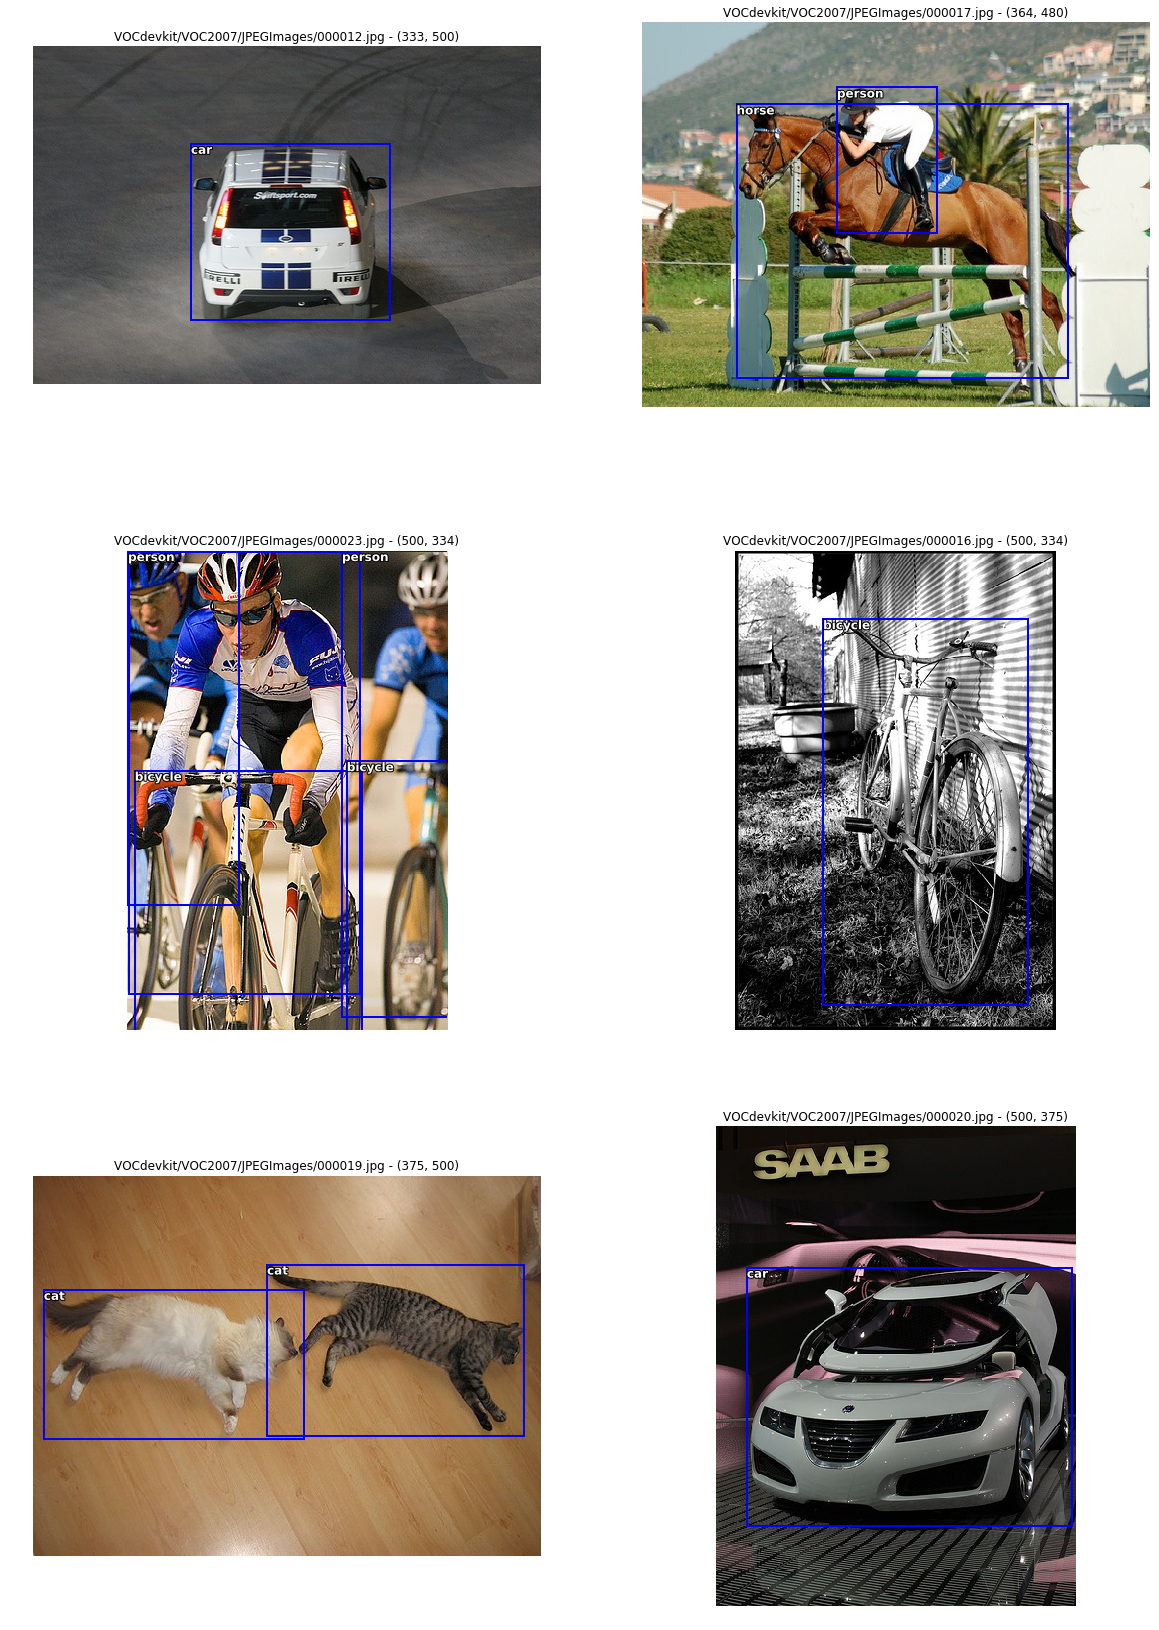

In [16]:
vizImages([12, 17, 23, 16, 19, 20], annotation_dict, train_annotation_categ)

## Criação de Datasets com aumento de dados

### Classes para Transformações

In [17]:
# Classes adaptadas do tutorial PyTorch Data Loading:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]
        new_h, new_w = int(self.output_size[0]), int(self.output_size[1])

        ratio_w = new_w / w
        ratio_h = new_h / h
        image = transform.resize(image, (new_h, new_w))

        bbox = [int(round(bbox[0] * ratio_w)),
                int(round(bbox[1] * ratio_h)),
                int(round(bbox[2] * ratio_w)),
                int(round(bbox[3] * ratio_h))]

        return {'image': image, 'bbox': bbox, 'label': sample['label']}


class RandomCrop(object):
    """Crop the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]
        new_h, new_w = int(self.output_size[0]), int(self.output_size[1])

        start_w = random.randint(0, w - new_w)
        start_h = random.randint(0, h - new_h)

        image = image[start_h:(start_h + new_h),start_w:(start_w + new_w)]

        start_bbox_w = bbox[0] - start_w
        start_bbox_h = bbox[1] - start_h
        end_bbox_w = bbox[2] + start_bbox_w
        end_bbox_h = bbox[3] + start_bbox_h
        start_bbox_w = max(0, start_bbox_w)
        start_bbox_h = max(0, start_bbox_h)

        bbox = [start_bbox_w,
                start_bbox_h,
                min(new_w, end_bbox_w) - start_bbox_w,
                min(new_h, end_bbox_h) - start_bbox_h]

        return {'image': image, 'bbox': bbox, 'label': sample['label']}


class RandomHorizontalFlip(object):
    """ Randomly mirror the image and the bounding box

    Args:
        prob (float): Probability to mirror the image.
    """

    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        if random.random() < self.prob:
            h, w = image.shape[:2]
            image = image[:,::-1,:]
            bbox = [w - (bbox[0] + bbox[2]),
                    bbox[1], bbox[2], bbox[3]]

        return {'image': image, 'bbox': bbox, 'label': sample['label']}


class Normalize(object):
    """Normalize image and bounding box arrays."""

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], reverse=False):
        self.mean = np.array([[mean]])
        self.std = np.array([[std]])
        self.reverse = reverse

    def __call__(self, sample):
        image = sample['image']
        bbox = sample['bbox']

        h, w = image.shape[:2]

        if self.reverse:
            image = image * self.std + self.mean

            bbox = np.array([int(round(bbox[0] * w)),
                             int(round(bbox[1] * h)),
                             int(round(bbox[2] * w)),
                             int(round(bbox[3] * h))])
        else:
            image = (image - self.mean) / self.std

            bbox = np.array([bbox[0] / w,
                             bbox[1] / h,
                             bbox[2] / w,
                             bbox[3] / h])

        label = np.array([sample['label']])

        return {'image': sample['image'],
                'bbox': bbox,
                'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sample['image'].transpose((2, 0, 1))
        label = np.concatenate((sample['bbox'], sample['label']))

        return {'image': torch.from_numpy(image).float(),
                #'bbox': torch.from_numpy(sample['bbox']).float(),
                #'label': torch.from_numpy(sample['label'])}
                'label': torch.from_numpy(label).float()}


class ToNumpy(object):
    """Convert tensors in sample to Numpy Arrays."""

    def __call__(self, sample):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = sample['image'].numpy().transpose((1, 2, 0))
        label = sample['label'].numpy()

        return {'image': image,
                'bbox': label[:4],
                'label': label[4:]}

### Classe para Dataset

In [18]:
class VOC2007Dataset(torch.utils.data.Dataset):
    def __init__(self, annotation, single_bbox=True, split=None, transforms=None):
        self.cv2_flags = cv2.IMREAD_UNCHANGED + cv2.IMREAD_ANYDEPTH + cv2.IMREAD_ANYCOLOR
        self.annotation = annotation
        self.single_bbox = single_bbox

        self.ids = list(annotation.keys())
        if split:
            assert len(split) == 2

            start_idx = int(len(self.ids) * split[0])
            end_idx = int(len(self.ids) * split[1])
            self.ids = self.ids[start_idx:end_idx]

        self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        image_id = self.ids[index]
        fp = self.annotation[image_id]['file_name']

        if self.single_bbox:
            sample = {'image': cv2.cvtColor(cv2.imread(fp, self.cv2_flags).astype(np.float32)/255, cv2.COLOR_BGR2RGB),
                      'bbox': self.annotation[image_id]['annot'][0]['bbox'],
                      'label': self.annotation[image_id]['annot'][0]['categ']}
        else:
            sample = {'image': cv2.cvtColor(cv2.imread(fp, self.cv2_flags).astype(np.float32)/255, cv2.COLOR_BGR2RGB),
                      'bbox': [entry['bbox'] for entry in self.annotation[image_id]['annot']],
                      'label': [entry['categ'] for entry in self.annotation[image_id]['annot']]}

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

### Criação das instâncias para treinamento, validação e teste

In [19]:
train_transforms = torchvision.transforms.Compose([
    RandomHorizontalFlip(),
    Rescale((256, 256)),
    RandomCrop((224, 224)),
    Normalize(),
    ToTensor()
])

test_transforms = torchvision.transforms.Compose([
    Rescale((224, 224)),
    Normalize(),
    ToTensor()
])

train_dataset = VOC2007Dataset(annotation_dict, split=[0.0, 0.7], transforms=train_transforms)
valid_dataset = VOC2007Dataset(annotation_dict, split=[0.7, 0.9], transforms=train_transforms)
test_dataset = VOC2007Dataset(annotation_dict, split=[0.9, 1.0], transforms=test_transforms)
print(f'Dataset para treinamento: {len(train_dataset)} amostras')
print(f'Dataset para validação: {len(valid_dataset)} amostras')
print(f'Dataset para teste: {len(test_dataset)} amostras')

Dataset para treinamento: 3507 amostras
Dataset para validação: 1002 amostras
Dataset para teste: 502 amostras


### Visualização de amostras

In [20]:
def vizDatasetImages(image_refs, data_obj, categ_dict):
    if type(image_refs) is range:
        image_ids = list(image_refs)
    elif type(image_refs) is list:
        image_ids = image_refs
    else:
        image_ids = [image_refs]

    num_imgs = len(image_ids)
    num_rows = int(np.ceil(num_imgs/2))

    fig = plt.figure(figsize=(20, 30))

    viz_transforms = torchvision.transforms.Compose([
        ToNumpy(),
        Normalize(reverse=True)
    ])

    for entry in range(num_imgs):
        idx = image_ids[entry]
        sample = viz_transforms(data_obj[idx])

        image = sample['image']
        bbox = sample['bbox'].tolist()
        label = sample['label'][0][0]

        # Draw image
        ax = fig.add_subplot(num_rows, 2, 1 + entry)
        ax.imshow(image)

        # Draw bounding box and category
        drawBbox(ax, bbox, categ_dict[label])

        height, width = image.shape[:2]
        ax.set_title(f'{str(idx)} - ({height}, {width})')
        ax.axis('off')

    plt.show()

#### Amostras de treinamento

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


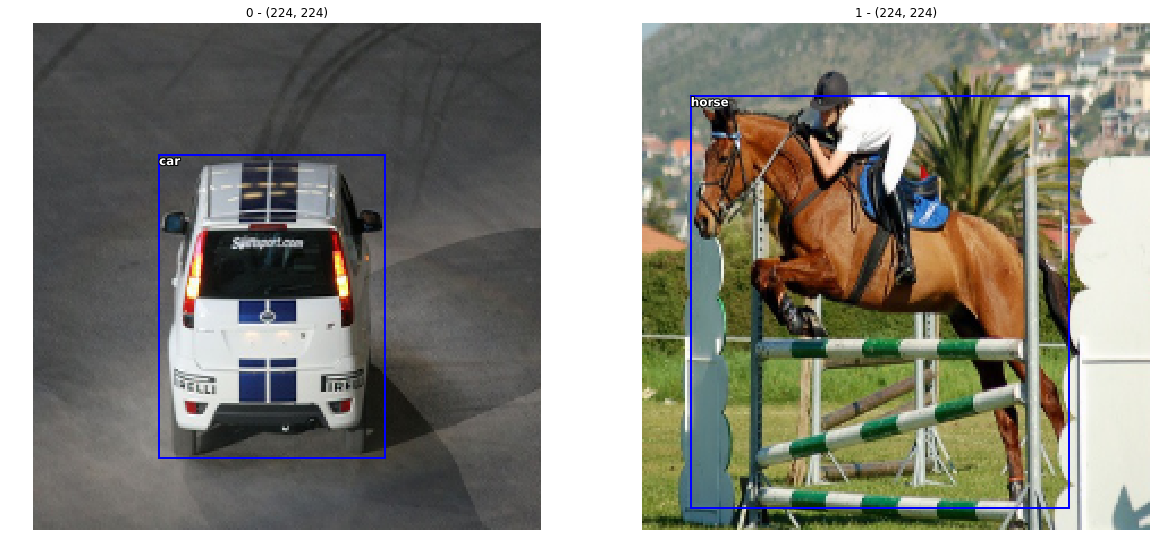

In [21]:
vizDatasetImages(range(2), train_dataset, train_annotation_categ)

#### Amostras de validação

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


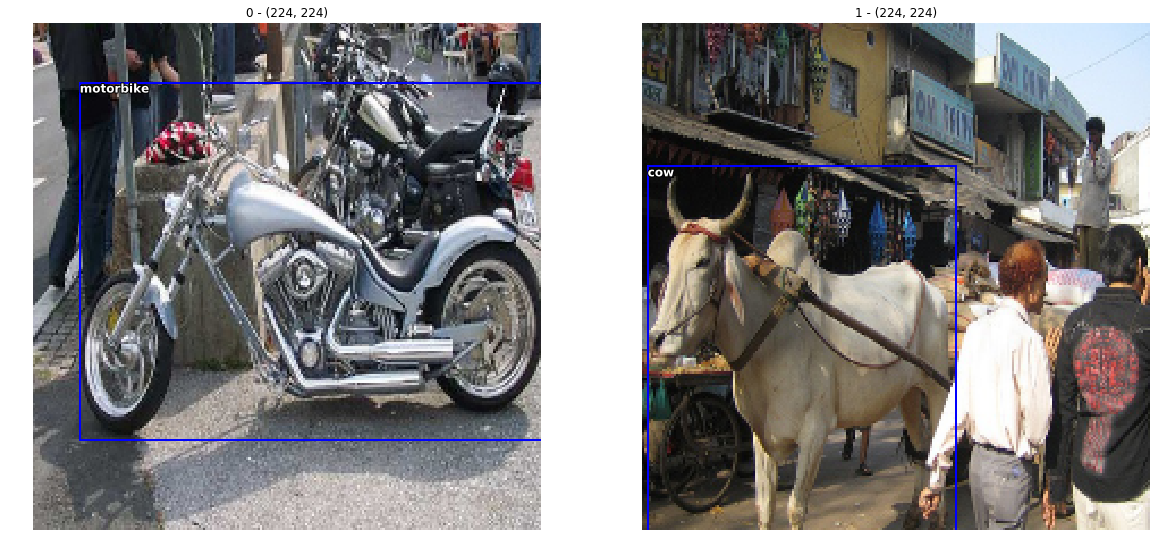

In [22]:
vizDatasetImages(range(2), valid_dataset, train_annotation_categ)

#### Amostras de teste

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


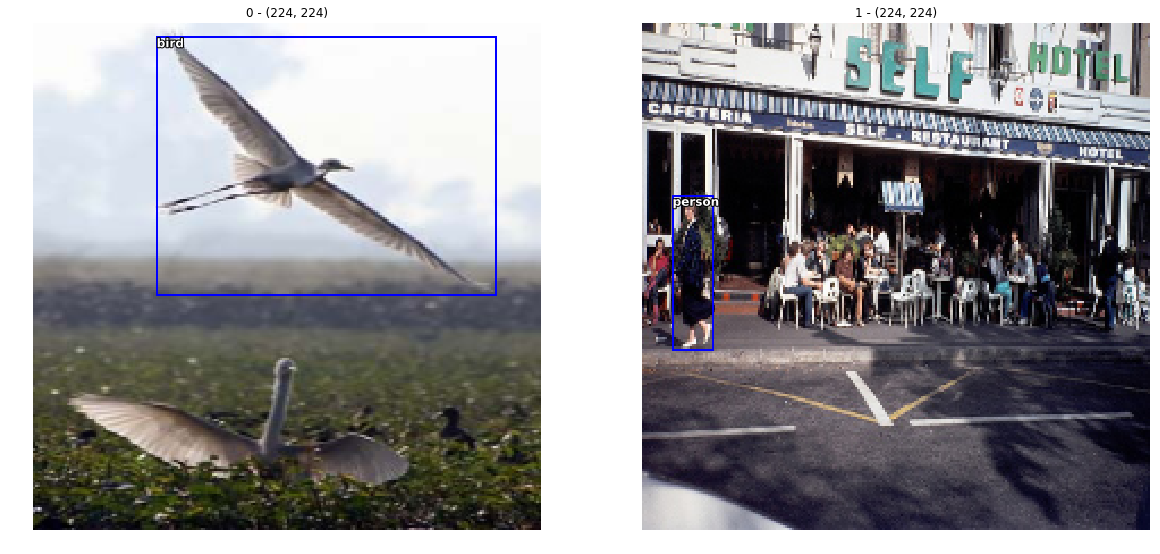

In [23]:
vizDatasetImages(range(2), test_dataset, train_annotation_categ)

## Processamento com rede neural

### Criação dos Dataloaders

In [24]:
batch_size = 8
nw = 0

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=nw)

### Declaração do modelo da Rede Neural

In [25]:
# Baseado em https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

class MyResNet18(torch.nn.Module):
    def __init__(self, num_labels):
        super().__init__()

        model = torchvision.models.resnet18(pretrained = True)

        model_children = list()
        child_counter = 0
        for child in model.children():
            if child_counter < 6:
                for param in child.parameters():
                    param.requires_grad = False
            elif child_counter == 6:
                children_of_child_counter = 0
                for children_of_child in child.children():
                    if children_of_child_counter < 1:
                        for param in children_of_child.parameters():
                            param.requires_grad = False
                    else:
                        pass
                    children_of_child_counter += 1

            else:
                pass

            model_children.append(child)
            child_counter += 1

        self.feat = torch.nn.Sequential(*model_children[:-1])
        self.cls = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features, 256),
                                       torch.nn.ReLU(inplace=True),
                                       torch.nn.Linear(256, (4 + num_labels)))

    def forward(self,x):
        x = self.feat(x)
        x = torch.squeeze(x)
        x = self.cls(x)

        return x

In [26]:
model = MyResNet18(len(train_annotation_categ))
model.to(device)

MyResNet18(
  (feat): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

#### Teste do modelo com amostra de treinamento

In [27]:
dataiter = iter(train_dataloader)
samples = dataiter.next()
print(f'Dimensão da entrada: {samples["image"].shape}')
print(f'Dimensão do target: {samples["label"].shape}')

Dimensão da entrada: torch.Size([8, 3, 224, 224])
Dimensão do target: torch.Size([8, 5])


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [28]:
samples_output = model.forward(samples['image'].to(device))
print(f'Dimensão da saída: {samples_output.shape}')

Dimensão da saída: torch.Size([8, 24])


### Declaração da Função de Perda customizada

In [29]:
class CompositeLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bbox_lf = torch.nn.MSELoss()
        self.label_lf = torch.nn.CrossEntropyLoss()

    def forward(self, out, target):
        out_bbox = out[:,:4]
        out_label = out[:,4:]
        target_bbox = target[:,:4].float()
        target_label = target[:,4].long()

        bbox_loss = self.bbox_lf(out_bbox, target_bbox)
        label_loss = self.label_lf(out_label, target_label-1)

        return bbox_loss + label_loss

In [30]:
crit = CompositeLoss()
loss_test = crit(samples_output, torch.autograd.Variable(samples['label']).to(device))
loss_test_value = loss_test.cpu().item()
print(f'Valor da função de perda customizada: {loss_test_value}')

Valor da função de perda customizada: 3.227735996246338


### Treinamento

In [31]:
n_epochs = 50

optm = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [32]:
num_train_samples = len(train_dataloader.dataset)
num_train_batches = num_train_samples // batch_size
num_valid_samples = len(valid_dataloader.dataset)
num_valid_batches = num_valid_samples // batch_size

batch_print_size = 10

epoch_train_loss_history = list()
epoch_valid_loss_history = list()
print('Start training for {} epochs'.format(n_epochs))

try:
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        train_t0 = time.time()
        epoch_train_loss = 0.0
        running_loss = 0.0

        for i, samples in enumerate(train_dataloader):
            # get the inputs
            images = samples['image'].to(device)
            labels = torch.autograd.Variable(samples['label'], requires_grad=True).to(device)

            # zero the parameter gradients
            optm.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = crit(outputs, labels)
            loss_value = loss.cpu().item()
            loss.backward()
            optm.step()

            # Update loss totals
            running_loss += loss_value
            epoch_train_loss += loss_value

            # print statistics
            if i % batch_print_size == (batch_print_size - 1):
                print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                running_loss = 0.0

        epoch_train_loss /= num_train_samples
        train_t1 = time.time() - train_t0


        valid_t0 = time.time()
        epoch_valid_loss = 0.0
        running_loss = 0.0

        with torch.no_grad():
            for i, samples in enumerate(valid_dataloader):
                # get the inputs
                images = samples['image'].to(device)
                labels = samples['label'].to(device)

                # forward
                outputs = model(images)
                loss = crit(outputs, labels)
                loss_value = loss.cpu().item()

                # Update loss totals
                running_loss += loss_value
                epoch_valid_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

        epoch_valid_loss /= num_valid_samples
        valid_t1 = time.time() - valid_t0

        epoch_train_loss_history.append(epoch_train_loss)
        epoch_valid_loss_history.append(epoch_valid_loss)

        print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

    print('Finished Training')
except KeyboardInterrupt:
    print('Finished by user')

Start training for 50 epochs


/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch   0 > train: T=122.3s | loss=0.46387955076442267  valid: T= 31.3s | loss=0.23872721290398025
Epoch   1 > train: T=131.3s | loss=0.31985549159222665  valid: T= 30.3s | loss=0.17542295303649294
Epoch   2 > train: T=129.3s | loss=0.24479757695922766  valid: T= 30.6s | loss=0.1444221486945352
Epoch   3 > train: T=132.4s | loss=0.21206852162295609  valid: T= 32.3s | loss=0.12967433038347972
Epoch   4 > train: T=135.1s | loss=0.17780991247450145  valid: T= 31.8s | loss=0.12264298958454779
Epoch   5 > train: T=132.0s | loss=0.15762582698336075  valid: T= 36.1s | loss=0.11355155590408576
Epoch   6 > train: T=137.6s | loss=0.13924841312965097  valid: T= 30.3s | loss=0.1105767278495187
Epoch   7 > train: T=125.2s | loss=0.1235903925048615  valid: T= 29.5s | loss=0.10990070252718326
Epoch   8 > train: T=120.5s | loss=0.11076186862908302  valid: T= 29.2s | loss=0.10961057904535187
Epoch   9 > train: T=122.5s | loss=0.09817830048499367  valid: T= 28.5s | loss=0.11175320870029236
Epoch  10 > t

### Evolução do treinamento

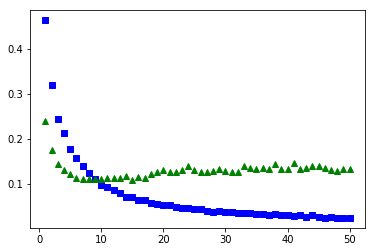

In [33]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Visualização dos resultados

In [34]:
num_test_samples = len(test_dataloader.dataset)

pred_list = list()
label_list = list()

with torch.no_grad():
    test_loss = 0.0

    for i, samples in enumerate(test_dataloader):
        # get the inputs
        inputs = samples['image'].to(device)
        label_list.append(samples['label'])

        # forward
        pred_list.append(model(inputs))

test_pred = torch.cat(tuple(pred_list), 0)
print(f'Dimensão dos rótulos (bounding boxes) preditos: {test_pred.shape}')
test_label = torch.cat(tuple(label_list), 0)
print(f'Dimensão dos rótulos (bounding boxes) originais: {test_label.shape}')

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Dimensão dos rótulos (bounding boxes) preditos: torch.Size([502, 24])
Dimensão dos rótulos (bounding boxes) originais: torch.Size([502, 5])


In [35]:
test_loss_list = list()

test_label = test_label.to(device)
for idx in range(test_pred.shape[0]):
    test_loss = crit(torch.unsqueeze(test_pred[idx], dim=0),
                     torch.unsqueeze(test_label[idx], dim=0))
    test_loss_list.append(test_loss.cpu().item())

test_loss_array = np.array(test_loss_list)
test_loss_idx = np.argsort(test_loss_array).tolist()
test_pred_array = test_pred.cpu().numpy()

In [36]:
def vizResults(image_refs, data_obj, categ_dict, pred_array):
    if type(image_refs) is range:
        image_ids = list(image_refs)
    elif type(image_refs) is list:
        image_ids = image_refs
    else:
        image_ids = [image_refs]

    num_imgs = len(image_ids)
    num_rows = int(np.ceil(num_imgs/2))

    fig = plt.figure(figsize=(20, 30))

    viz_transforms = torchvision.transforms.Compose([
        ToNumpy(),
        Normalize(reverse=True)
    ])

    for entry in range(num_imgs):
        idx = image_ids[entry]
        sample = viz_transforms(data_obj[idx])

        image = sample['image']
        bbox = sample['bbox'].tolist()
        label = sample['label'][0][0]

        # Draw image
        ax = fig.add_subplot(num_rows, 2, 1 + entry)
        ax.imshow(image)

        # Draw bounding box and category
        drawBbox(ax, bbox, categ_dict[label])

        height, width = image.shape[:2]
        pred_bbox = [int(round(pred_array[idx][0] * width)),
                     int(round(pred_array[idx][1] * height)),
                     int(round(pred_array[idx][2] * width)),
                     int(round(pred_array[idx][3] * height))]
        pred_label = categ_dict[np.argsort(pred_array[idx][4:])[-1] + 1]
        drawBbox(ax, pred_bbox, pred_label, box_color='red')

        ax.set_title(f'{str(idx)} - ({height}, {width})')
        ax.axis('off')

    plt.show()

#### Melhores resultados

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


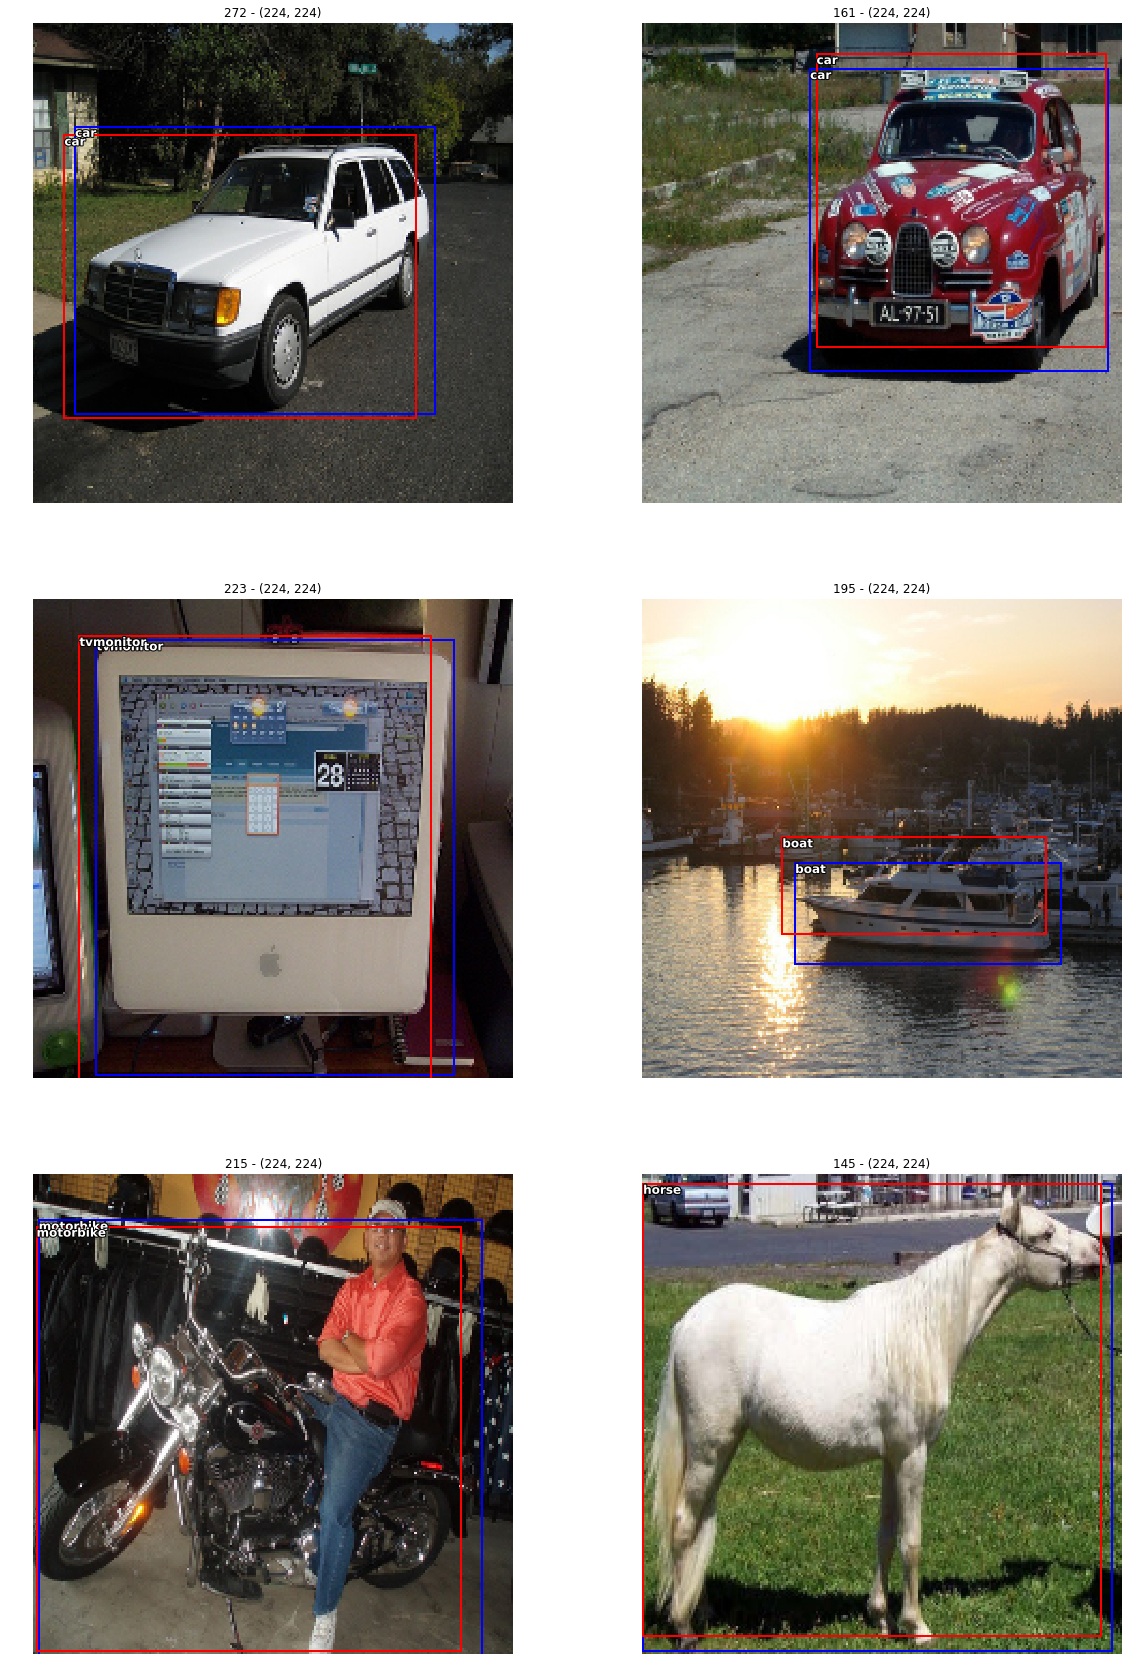

In [37]:
vizResults(test_loss_idx[:6], test_dataset, train_annotation_categ, test_pred_array)

#### Piores resultados

/home/adriano/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


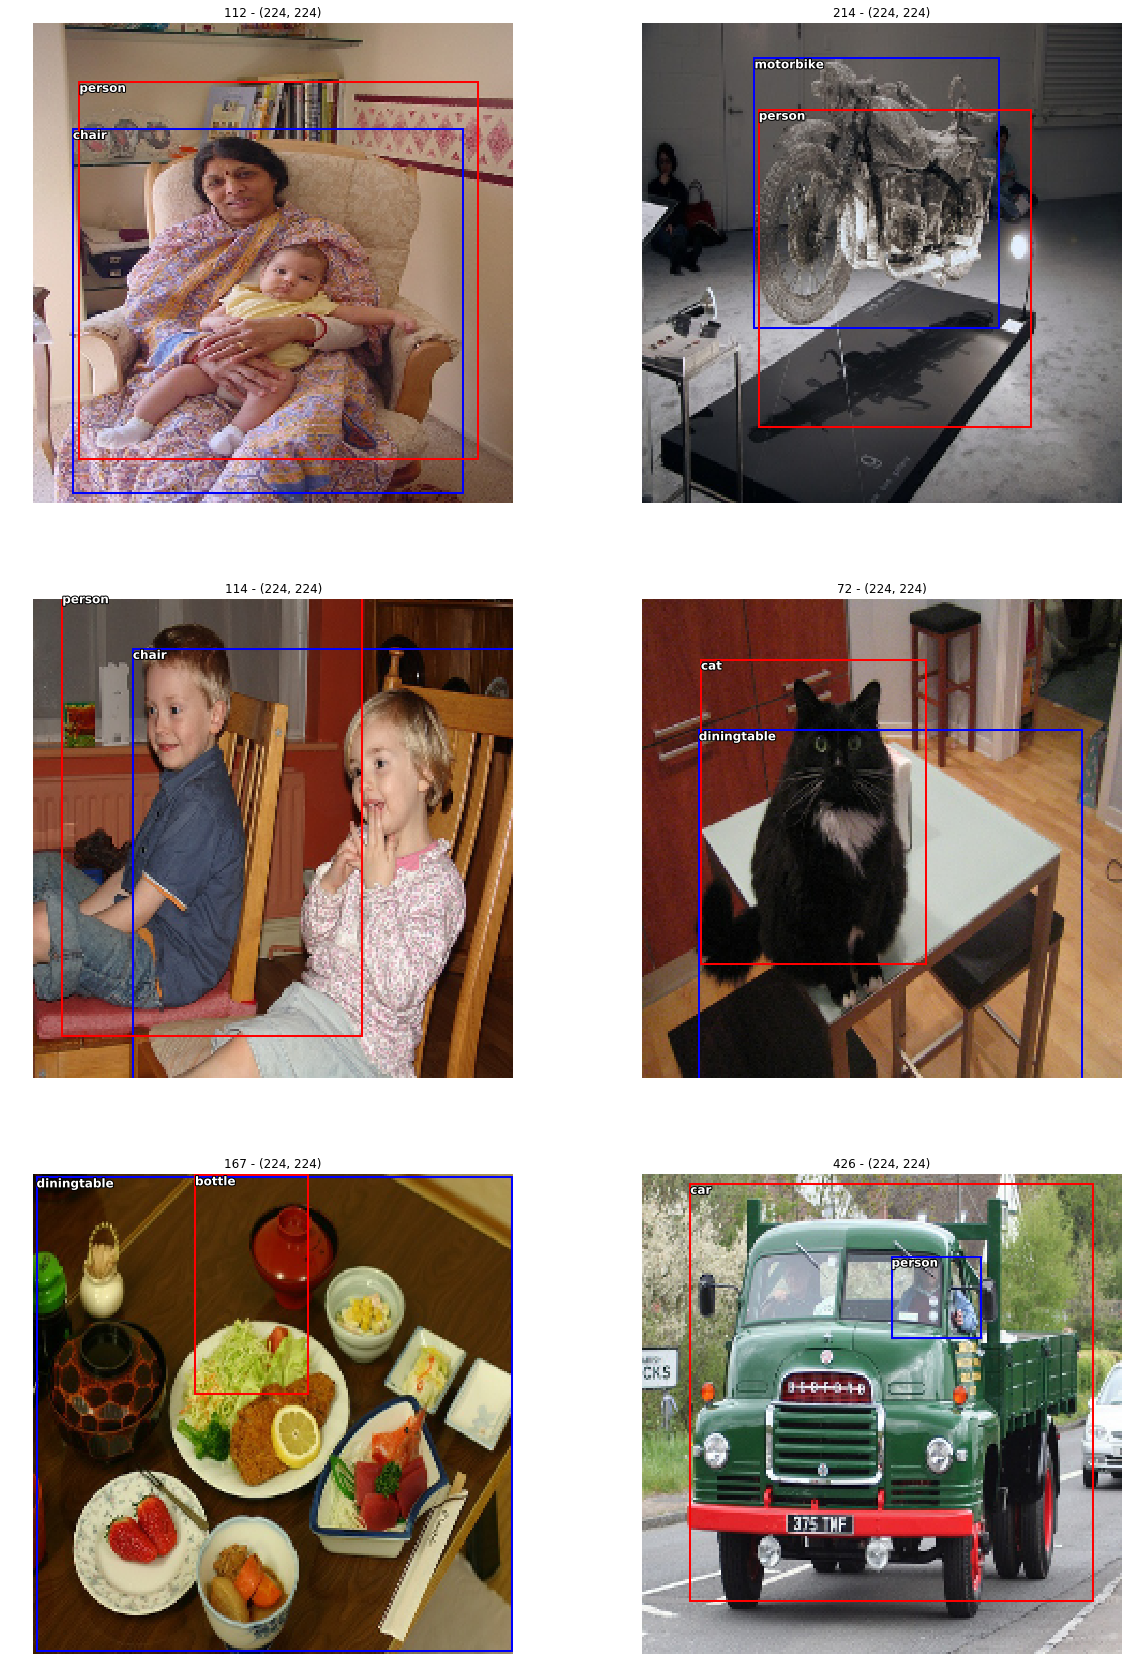

In [38]:
vizResults(test_loss_idx[-6:], test_dataset, train_annotation_categ, test_pred_array)